In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
from scipy.interpolate import RBFInterpolator, InterpolatedUnivariateSpline
import scipy.special as special
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

import os
os.chdir(os.getcwd())

In [2]:
N = 15       # number of loops
lc = 0.12     # magnetic core length / m
l = 7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # degauss frequency
T = 35       # deguass time
V_gain = 3.6
# R = 1 * 3.6 / 6  # resistance calculate
R = 0.88
gain = 20

#### Get data from file and subtract the offset for both voltage read

In [3]:
def get_data(fname,off_set):
    time_stamp = []
    Vin = []
    Vpick = []
    for i in off_set:
        with h5py.File(fname, "a") as f:
            dset = f[f"{i}off"]
            time_stamp.append(dset[0])
            Vin.append(dset[1])
            Vpick.append(dset[2])
    return np.array(time_stamp[0]), np.array(Vin[0]),np.array(Vpick[0])

def get_off(fname,runname = "off"):
    off_set = []
    off_get = []
    with h5py.File(fname, "a") as f:
        dset = f[runname]
        off_set.append(dset[0])
        off_get.append(dset[1])
    return np.array(off_set[0]), np.array(off_get[0])

def off_fit(off_set,off_get):
    coef = np.polyfit(off_set, off_get, 1)
    poly1d_fn = np.poly1d(coef) 
    return poly1d_fn


def off_subtract(Vin,Vpick,off_set,fitfun):
    input_off_fit = fitfun(off_set)/1000/3.6
    input_off_mea = np.mean(Vin[-50000:-1])
    print(input_off_mea)
    print(input_off_fit)
    Vin_sub = Vin - input_off_mea + input_off_fit
    pick_off_mea = np.mean(Vpick[-50000:-1])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [7]:
file_name = "degauss_3_20_2024.hdf"
off = [0]
mea_time, Vin, Vpick = get_data(file_name,off)   # get both input voltage and pickup voltage
off_set, off_get = get_off(file_name)        # get offset calibration measured before
off_fit_fun = off_fit(off_set, off_get) 
#Vin_mea, Vpick_mea = off_subtract(Vin,Vpick,off[0],off_fit_fun)

IndexError: Index (2) out of range for (0-1)

Text(0, 0.5, 'voltage / V')

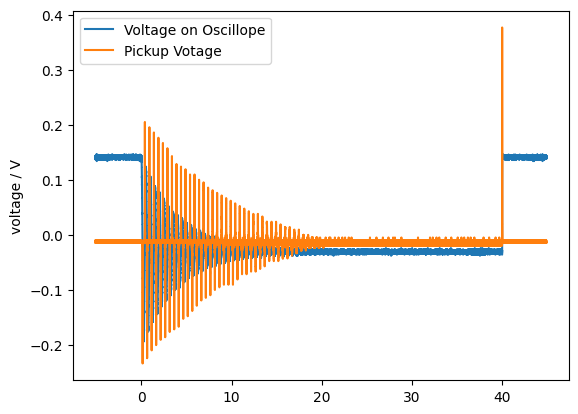

In [5]:
plt.plot(mea_time,Vin, label =  "Voltage on Oscillope")
plt.plot(mea_time,Vpick, label =  "Pickup Votage")
plt.legend()
plt.ylabel("voltage / V")

#### Find initial peak (starting of the integral) and do the integral

In [8]:
dt = (mea_time[-1] - mea_time[0])/len(mea_time)
N_data  = int((T - 1/fre)/dt)
# peaks,_ = find_peaks(-Vpick,distance=500, height = max(-Vpick)*0.5)
# print(peaks)
# time_uesd = mea_time[peaks[0]:peaks[0] + N_data]
# Vin_used  = Vin[peaks[0]:peaks[0]+ N_data] 
# Vpick_used = Vpick[peaks[0]:peaks[0] + N_data] 
Vin_mea, Vpick_mea = off_subtract(Vin,Vpick,off[0],off_fit_fun)
I = Vin_mea * V_gain /R
H = np.array(I) * N / lc
print(H[-100:-1])

0.05334086681733635
7.588888888888942e-05
[44.35313629 45.37586356 44.35313629 45.37586356 45.37586356 45.37586356
 44.35313629 44.35313629 45.37586356 44.35313629 43.33040901 44.35313629
 44.35313629 44.35313629 44.35313629 45.37586356 44.35313629 45.37586356
 44.35313629 44.35313629 43.33040901 44.35313629 44.35313629 44.35313629
 44.35313629 44.35313629 45.37586356 43.33040901 45.37586356 44.35313629
 44.35313629 44.35313629 45.37586356 44.35313629 44.35313629 45.37586356
 46.39859083 44.35313629 45.37586356 44.35313629 45.37586356 44.35313629
 44.35313629 44.35313629 44.35313629 44.35313629 44.35313629 44.35313629
 45.37586356 45.37586356 45.37586356 45.37586356 44.35313629 44.35313629
 45.37586356 44.35313629 44.35313629 45.37586356 45.37586356 44.35313629
 45.37586356 45.37586356 45.37586356 43.33040901 44.35313629 44.35313629
 45.37586356 44.35313629 45.37586356 44.35313629 43.33040901 45.37586356
 44.35313629 44.35313629 44.35313629 44.35313629 44.35313629 44.35313629
 44.35313

250000
3.221931656095326e-18


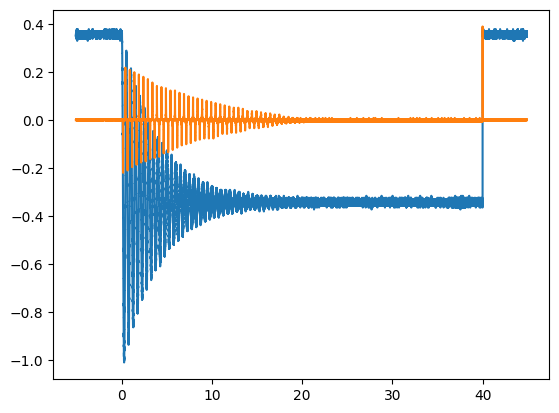

In [10]:
plt.plot(mea_time,I)
plt.plot(mea_time,Vpick_mea)
print(len(Vpick_mea))
print(np.mean(Vpick_mea[-50000:-1]))

In [231]:
B = []
B_int = []
Bini = [0]
dB = np.array(Vpick_mea)/Ac/N/gain
for a in dB[0:-1]:
        Bini.append(Bini[-1] + (a)* dt )
B.append(Bini)
print(B[0])

[0, -0.029184510687470303, -0.058369021374940606, -0.08692264213909053, -0.11547626290324045, -0.14339899374406997, -0.17069083466157914, -0.19735178565576791, -0.2233818467266363, -0.24878101787418433, -0.27418018902173236, -0.2983175803226396, -0.32182408170022647, -0.344699693154493, -0.36757530460875953, -0.3898200261397057, -0.41143385774733143, -0.4324167994316368, -0.4527688511926218, -0.47249001303028637, -0.49221117486795096, -0.5113014467822952, -0.529760828773319, -0.5482202107643428, -0.5660487028320462, -0.5832463049764294, -0.6004439071208125, -0.6170106193418753, -0.6329464416396177, -0.6482513740140396, -0.6635563063884616, -0.6782303488395632, -0.6922735013673444, -0.7063166538951257, -0.7197289164995865, -0.7331411791040473, -0.7459225517851877, -0.7580730345430078, -0.7702235173008278, -0.7817431101353275, -0.7932627029698271, -0.8041514058810064, -0.8150401087921857, -0.825928811703365, -0.8361866246912238, -0.8464444376790827, -0.8560713607436212, -0.86569828380815

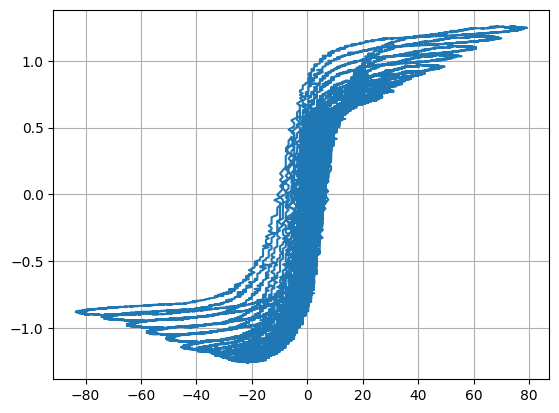

In [232]:
plt.plot(H,B[0]-(max(B[0])+min(B[0]))/2,"-")
plt.grid(True)

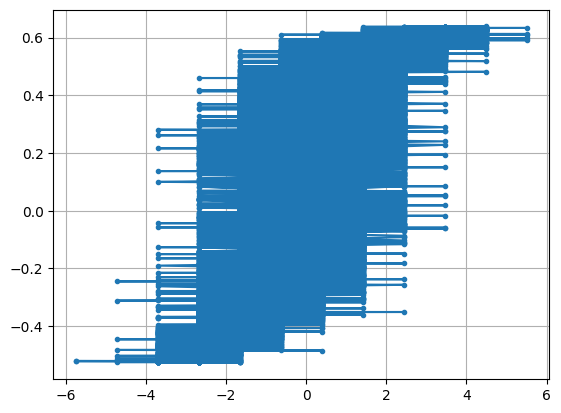

In [233]:
plt.plot(H[-110000:-1],B[0][-110000:-1]-(max(B[0])+min(B[0]))/2,".-")
plt.grid(True)

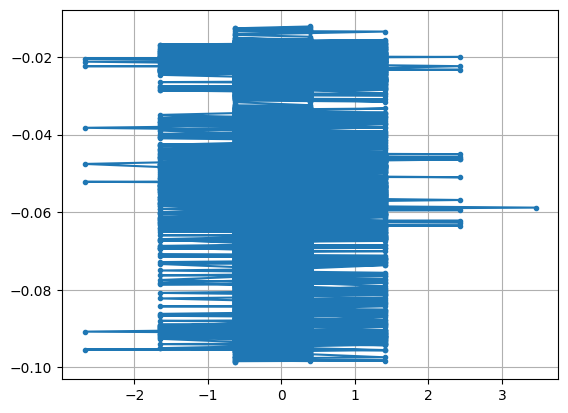

In [234]:
plt.plot(H[-9000:-1],B[0][-9000:-1]-(max(B[0])+min(B[0]))/2,".-")
plt.grid(True)

Text(0.5, 0, 'offset set / mV')

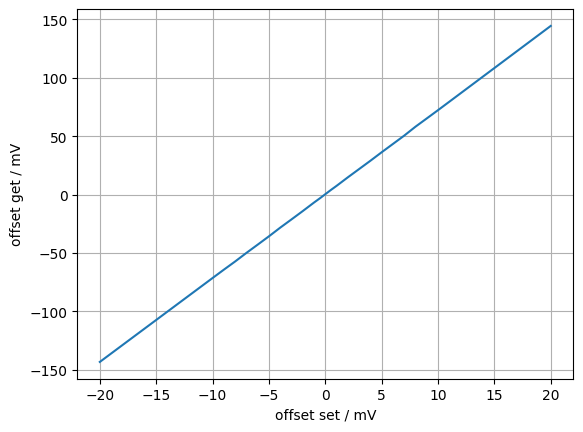

In [21]:
plt.plot(off_set,off_get)
plt.grid(True)
plt.ylabel("offset get / mV")
plt.xlabel("offset set / mV")

In [135]:
print(H[-1])

-0.6147159090909007
